In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    
    ap_residual = MaxPooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalMaxPool2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 32)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 32)   128         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 32)     9216        spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 32)     128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 32)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 32)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 32)           0           spatial_dropout2d_9[0][0]        
__________

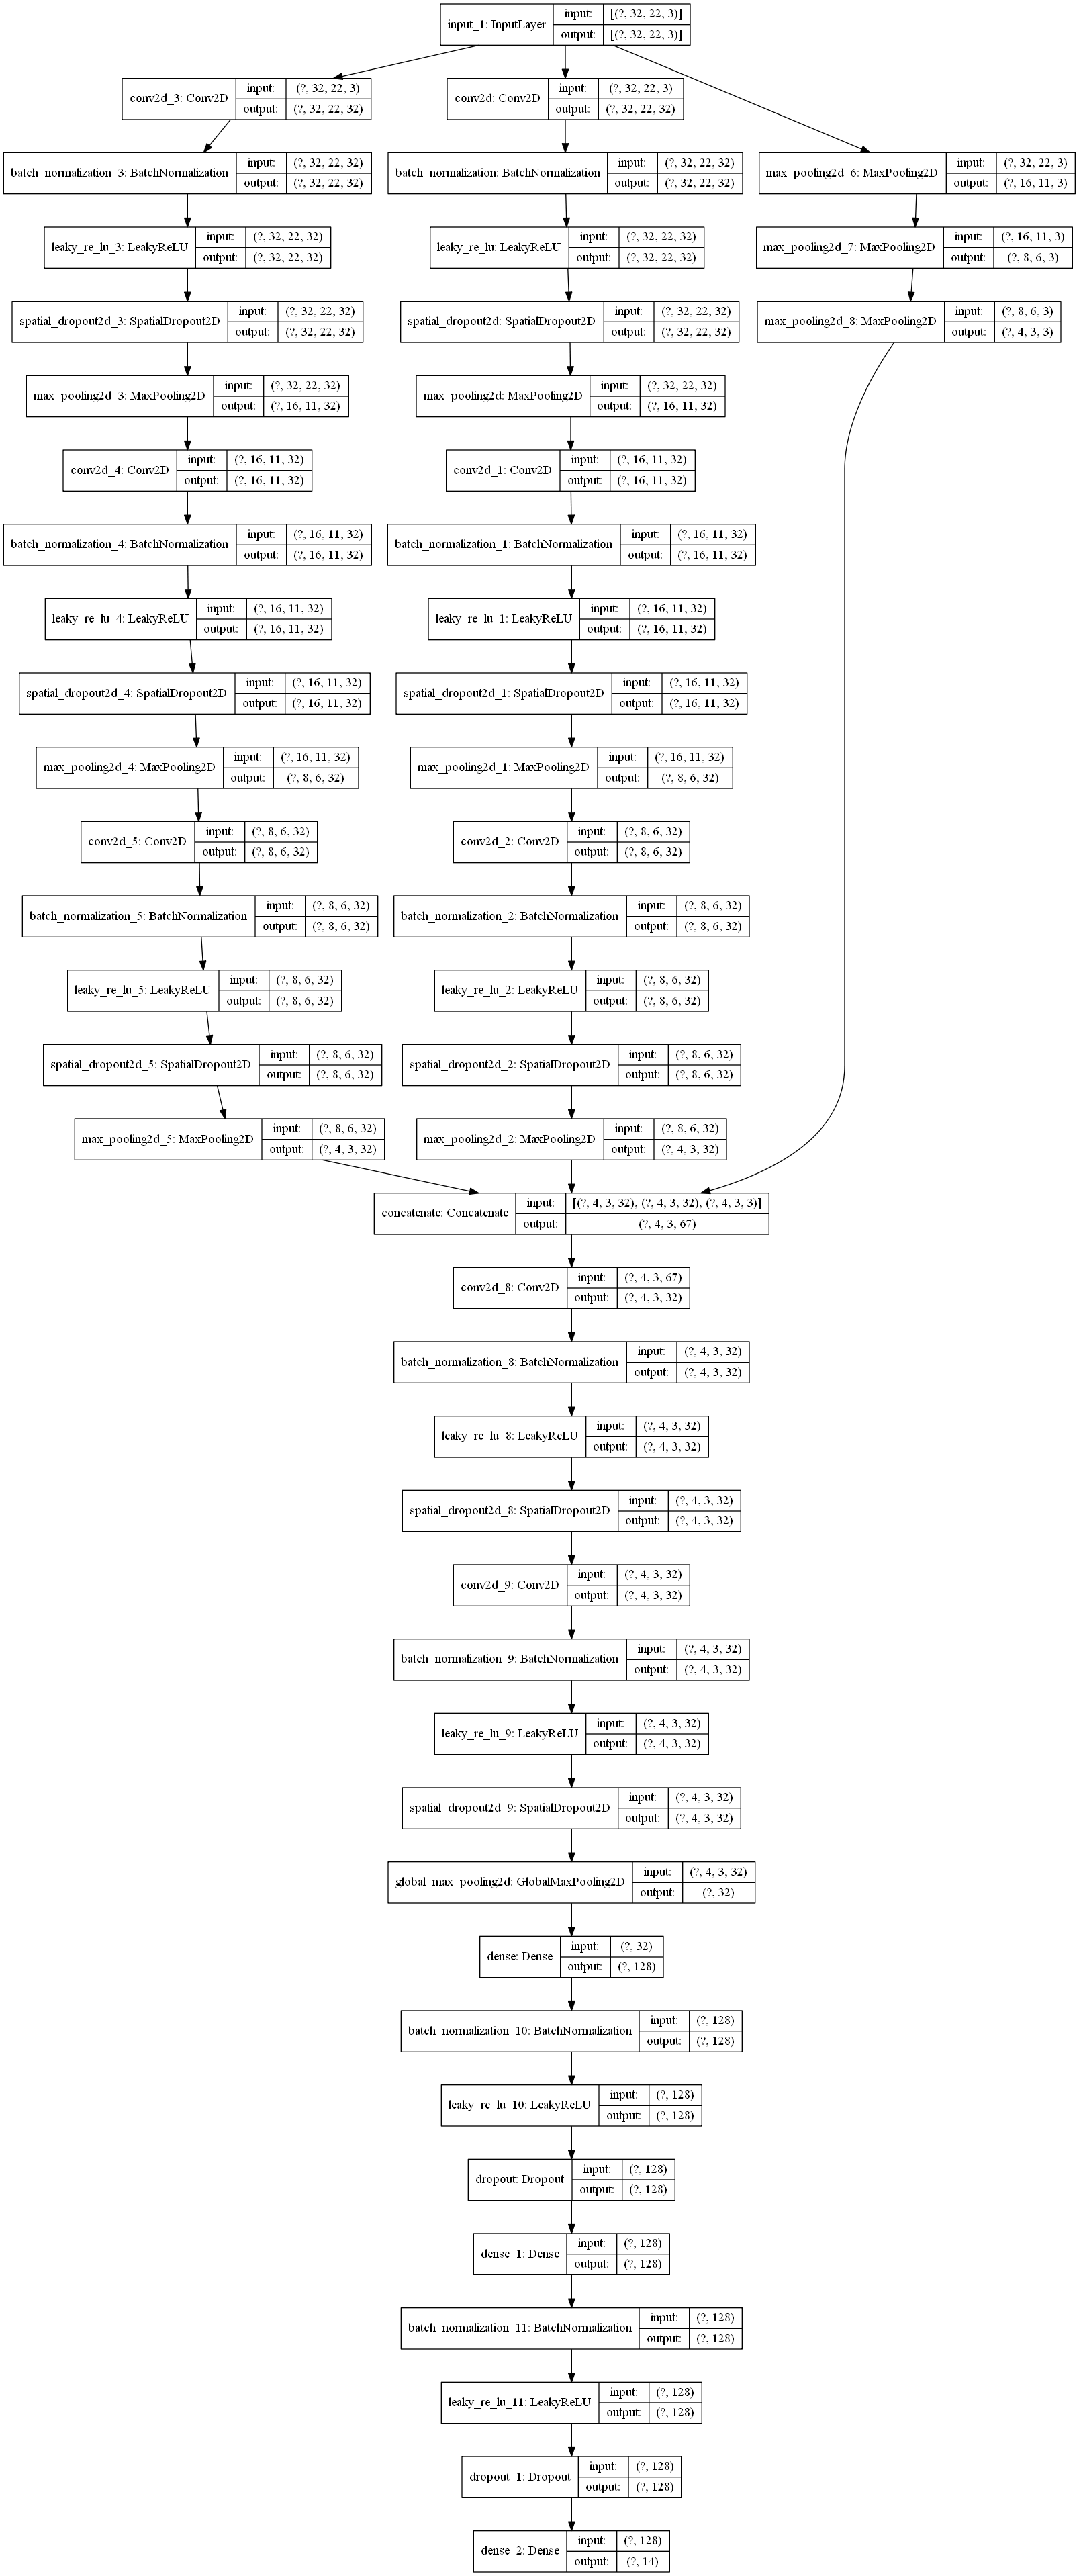

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 20/1960 [00:00<00:09, 196.56it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 210.30it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:03<00:00, 211.25it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:32 - loss: 3.1499 - acc: 0.156 - ETA: 47s - loss: 3.0215 - acc: 0.156 - ETA: 32s - loss: 2.9289 - acc: 0.16 - ETA: 24s - loss: 2.8684 - acc: 0.14 - ETA: 19s - loss: 2.8151 - acc: 0.13 - ETA: 16s - loss: 2.7586 - acc: 0.14 - ETA: 14s - loss: 2.7115 - acc: 0.15 - ETA: 12s - loss: 2.6831 - acc: 0.14 - ETA: 11s - loss: 2.6716 - acc: 0.14 - ETA: 10s - loss: 2.6343 - acc: 0.14 - ETA: 9s - loss: 2.5900 - acc: 0.1619 - ETA: 8s - loss: 2.5735 - acc: 0.164 - ETA: 8s - loss: 2.5467 - acc: 0.165 - ETA: 7s - loss: 2.5328 - acc: 0.165 - ETA: 7s - loss: 2.5319 - acc: 0.160 - ETA: 6s - loss: 2.5205 - acc: 0.169 - ETA: 6s - loss: 2.4939 - acc: 0.178 - ETA: 5s - loss: 2.4773 - acc: 0.182 - ETA: 5s - loss: 2.4519 - acc: 0.194 - ETA: 5s - loss: 2.4292 - acc: 0.206 - ETA: 5s - loss: 2.4124 - acc: 0.214 - ETA: 4s - loss: 2.3897 - acc: 0.223 - ETA: 4s - loss: 2.3709 - acc: 0.226 - ETA: 4s - loss: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.6822 - acc: 0.781 - ETA: 3s - loss: 0.5937 - acc: 0.843 - ETA: 3s - loss: 0.6302 - acc: 0.812 - ETA: 3s - loss: 0.5906 - acc: 0.843 - ETA: 3s - loss: 0.5996 - acc: 0.825 - ETA: 3s - loss: 0.5808 - acc: 0.843 - ETA: 3s - loss: 0.5525 - acc: 0.857 - ETA: 2s - loss: 0.5579 - acc: 0.847 - ETA: 2s - loss: 0.5524 - acc: 0.843 - ETA: 2s - loss: 0.5360 - acc: 0.846 - ETA: 2s - loss: 0.5239 - acc: 0.858 - ETA: 2s - loss: 0.5241 - acc: 0.854 - ETA: 2s - loss: 0.5353 - acc: 0.851 - ETA: 2s - loss: 0.5342 - acc: 0.848 - ETA: 2s - loss: 0.5293 - acc: 0.847 - ETA: 2s - loss: 0.5211 - acc: 0.847 - ETA: 2s - loss: 0.5370 - acc: 0.840 - ETA: 2s - loss: 0.5413 - acc: 0.836 - ETA: 2s - loss: 0.5349 - acc: 0.835 - ETA: 2s - loss: 0.5452 - acc: 0.829 - ETA: 2s - loss: 0.5347 - acc: 0.836 - ETA: 2s - loss: 0.5328 - acc: 0.836 - ETA: 2s - loss: 0.5361 - acc: 0.832 - ETA: 2s - loss: 0.5485 - acc: 0.830 - ETA: 2s - loss: 0.5517 - acc: 0.831 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.4036 - acc: 0.906 - ETA: 3s - loss: 0.4498 - acc: 0.843 - ETA: 3s - loss: 0.5261 - acc: 0.833 - ETA: 3s - loss: 0.4895 - acc: 0.843 - ETA: 3s - loss: 0.5330 - acc: 0.850 - ETA: 3s - loss: 0.4930 - acc: 0.859 - ETA: 3s - loss: 0.5270 - acc: 0.848 - ETA: 2s - loss: 0.5829 - acc: 0.832 - ETA: 2s - loss: 0.5716 - acc: 0.829 - ETA: 2s - loss: 0.5531 - acc: 0.837 - ETA: 2s - loss: 0.5496 - acc: 0.838 - ETA: 2s - loss: 0.5455 - acc: 0.841 - ETA: 2s - loss: 0.5327 - acc: 0.843 - ETA: 2s - loss: 0.5438 - acc: 0.841 - ETA: 2s - loss: 0.5299 - acc: 0.845 - ETA: 2s - loss: 0.5320 - acc: 0.845 - ETA: 2s - loss: 0.5191 - acc: 0.849 - ETA: 2s - loss: 0.4988 - acc: 0.855 - ETA: 2s - loss: 0.4893 - acc: 0.856 - ETA: 2s - loss: 0.5069 - acc: 0.850 - ETA: 2s - loss: 0.4957 - acc: 0.854 - ETA: 2s - loss: 0.4901 - acc: 0.855 - ETA: 2s - loss: 0.4896 - acc: 0.851 - ETA: 2s - loss: 0.4816 - acc: 0.855 - ETA: 2s - loss: 0.4767 - acc: 0.855 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.3565 - acc: 0.875 - ETA: 3s - loss: 0.2665 - acc: 0.906 - ETA: 3s - loss: 0.2740 - acc: 0.895 - ETA: 3s - loss: 0.2706 - acc: 0.906 - ETA: 3s - loss: 0.2661 - acc: 0.912 - ETA: 3s - loss: 0.2753 - acc: 0.911 - ETA: 2s - loss: 0.2735 - acc: 0.910 - ETA: 2s - loss: 0.2637 - acc: 0.910 - ETA: 2s - loss: 0.2702 - acc: 0.913 - ETA: 2s - loss: 0.2812 - acc: 0.912 - ETA: 2s - loss: 0.2757 - acc: 0.914 - ETA: 2s - loss: 0.2636 - acc: 0.916 - ETA: 2s - loss: 0.2817 - acc: 0.911 - ETA: 2s - loss: 0.2911 - acc: 0.906 - ETA: 2s - loss: 0.3199 - acc: 0.902 - ETA: 2s - loss: 0.3403 - acc: 0.896 - ETA: 2s - loss: 0.3376 - acc: 0.897 - ETA: 2s - loss: 0.3352 - acc: 0.901 - ETA: 2s - loss: 0.3267 - acc: 0.904 - ETA: 2s - loss: 0.3211 - acc: 0.906 - ETA: 2s - loss: 0.3303 - acc: 0.903 - ETA: 2s - loss: 0.3339 - acc: 0.902 - ETA: 2s - loss: 0.3272 - acc: 0.902 - ETA: 2s - loss: 0.3243 - acc: 0.903 - ETA: 2s - loss: 0.3316 - acc: 0.902 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1653 - acc: 0.937 - ETA: 3s - loss: 0.1632 - acc: 0.953 - ETA: 3s - loss: 0.2030 - acc: 0.927 - ETA: 3s - loss: 0.2713 - acc: 0.914 - ETA: 3s - loss: 0.2438 - acc: 0.918 - ETA: 3s - loss: 0.2443 - acc: 0.927 - ETA: 3s - loss: 0.2528 - acc: 0.919 - ETA: 3s - loss: 0.2599 - acc: 0.914 - ETA: 2s - loss: 0.2870 - acc: 0.909 - ETA: 2s - loss: 0.2806 - acc: 0.912 - ETA: 2s - loss: 0.2796 - acc: 0.917 - ETA: 2s - loss: 0.2911 - acc: 0.916 - ETA: 2s - loss: 0.2859 - acc: 0.918 - ETA: 2s - loss: 0.2777 - acc: 0.919 - ETA: 2s - loss: 0.2915 - acc: 0.916 - ETA: 2s - loss: 0.2807 - acc: 0.921 - ETA: 2s - loss: 0.2741 - acc: 0.922 - ETA: 2s - loss: 0.2772 - acc: 0.923 - ETA: 2s - loss: 0.2714 - acc: 0.926 - ETA: 2s - loss: 0.2671 - acc: 0.925 - ETA: 2s - loss: 0.2818 - acc: 0.922 - ETA: 2s - loss: 0.2759 - acc: 0.924 - ETA: 2s - loss: 0.2691 - acc: 0.926 - ETA: 2s - loss: 0.2652 - acc: 0.927 - ETA: 2s - loss: 0.2708 - acc: 0.922 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1401 - acc: 0.968 - ETA: 3s - loss: 0.1381 - acc: 0.953 - ETA: 3s - loss: 0.1565 - acc: 0.937 - ETA: 3s - loss: 0.1532 - acc: 0.953 - ETA: 3s - loss: 0.1695 - acc: 0.943 - ETA: 3s - loss: 0.1643 - acc: 0.942 - ETA: 3s - loss: 0.2094 - acc: 0.924 - ETA: 2s - loss: 0.2088 - acc: 0.921 - ETA: 2s - loss: 0.2242 - acc: 0.920 - ETA: 2s - loss: 0.2308 - acc: 0.921 - ETA: 2s - loss: 0.2427 - acc: 0.923 - ETA: 2s - loss: 0.2401 - acc: 0.924 - ETA: 2s - loss: 0.2576 - acc: 0.918 - ETA: 2s - loss: 0.2527 - acc: 0.919 - ETA: 2s - loss: 0.2528 - acc: 0.916 - ETA: 2s - loss: 0.2597 - acc: 0.918 - ETA: 2s - loss: 0.2563 - acc: 0.917 - ETA: 2s - loss: 0.2510 - acc: 0.920 - ETA: 2s - loss: 0.2434 - acc: 0.922 - ETA: 2s - loss: 0.2448 - acc: 0.923 - ETA: 2s - loss: 0.2383 - acc: 0.925 - ETA: 2s - loss: 0.2364 - acc: 0.927 - ETA: 2s - loss: 0.2336 - acc: 0.928 - ETA: 2s - loss: 0.2311 - acc: 0.928 - ETA: 2s - loss: 0.2243 - acc: 0.931 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0981 - acc: 0.968 - ETA: 3s - loss: 0.0991 - acc: 0.984 - ETA: 3s - loss: 0.2004 - acc: 0.968 - ETA: 3s - loss: 0.2272 - acc: 0.937 - ETA: 3s - loss: 0.2257 - acc: 0.937 - ETA: 3s - loss: 0.2103 - acc: 0.947 - ETA: 3s - loss: 0.2277 - acc: 0.942 - ETA: 3s - loss: 0.2131 - acc: 0.945 - ETA: 2s - loss: 0.2015 - acc: 0.947 - ETA: 2s - loss: 0.1951 - acc: 0.950 - ETA: 2s - loss: 0.2007 - acc: 0.946 - ETA: 2s - loss: 0.2015 - acc: 0.945 - ETA: 2s - loss: 0.1939 - acc: 0.947 - ETA: 2s - loss: 0.2025 - acc: 0.944 - ETA: 2s - loss: 0.1919 - acc: 0.947 - ETA: 2s - loss: 0.1853 - acc: 0.951 - ETA: 2s - loss: 0.1850 - acc: 0.950 - ETA: 2s - loss: 0.1842 - acc: 0.949 - ETA: 2s - loss: 0.1838 - acc: 0.950 - ETA: 2s - loss: 0.1826 - acc: 0.951 - ETA: 2s - loss: 0.1852 - acc: 0.947 - ETA: 2s - loss: 0.1845 - acc: 0.946 - ETA: 2s - loss: 0.1930 - acc: 0.945 - ETA: 2s - loss: 0.1909 - acc: 0.944 - ETA: 2s - loss: 0.1965 - acc: 0.940 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1286 - acc: 0.906 - ETA: 3s - loss: 0.2723 - acc: 0.906 - ETA: 3s - loss: 0.3525 - acc: 0.906 - ETA: 3s - loss: 0.2898 - acc: 0.914 - ETA: 3s - loss: 0.2615 - acc: 0.925 - ETA: 3s - loss: 0.2598 - acc: 0.921 - ETA: 3s - loss: 0.2528 - acc: 0.924 - ETA: 3s - loss: 0.2397 - acc: 0.925 - ETA: 3s - loss: 0.2506 - acc: 0.927 - ETA: 2s - loss: 0.2390 - acc: 0.928 - ETA: 2s - loss: 0.2332 - acc: 0.929 - ETA: 2s - loss: 0.2291 - acc: 0.932 - ETA: 2s - loss: 0.2167 - acc: 0.935 - ETA: 2s - loss: 0.2109 - acc: 0.935 - ETA: 2s - loss: 0.2205 - acc: 0.935 - ETA: 2s - loss: 0.2124 - acc: 0.937 - ETA: 2s - loss: 0.2118 - acc: 0.939 - ETA: 2s - loss: 0.2051 - acc: 0.942 - ETA: 2s - loss: 0.2038 - acc: 0.944 - ETA: 2s - loss: 0.2087 - acc: 0.940 - ETA: 2s - loss: 0.2087 - acc: 0.940 - ETA: 2s - loss: 0.2077 - acc: 0.941 - ETA: 2s - loss: 0.2046 - acc: 0.940 - ETA: 2s - loss: 0.2000 - acc: 0.942 - ETA: 2s - loss: 0.1944 - acc: 0.945 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0964 - acc: 1.000 - ETA: 3s - loss: 0.0575 - acc: 1.000 - ETA: 3s - loss: 0.0613 - acc: 1.000 - ETA: 3s - loss: 0.0611 - acc: 0.992 - ETA: 3s - loss: 0.0706 - acc: 0.987 - ETA: 3s - loss: 0.0735 - acc: 0.984 - ETA: 3s - loss: 0.0764 - acc: 0.986 - ETA: 3s - loss: 0.0901 - acc: 0.980 - ETA: 3s - loss: 0.1135 - acc: 0.968 - ETA: 3s - loss: 0.1259 - acc: 0.959 - ETA: 3s - loss: 0.1313 - acc: 0.957 - ETA: 3s - loss: 0.1309 - acc: 0.955 - ETA: 3s - loss: 0.1263 - acc: 0.959 - ETA: 2s - loss: 0.1250 - acc: 0.959 - ETA: 2s - loss: 0.1304 - acc: 0.956 - ETA: 2s - loss: 0.1322 - acc: 0.955 - ETA: 2s - loss: 0.1353 - acc: 0.954 - ETA: 2s - loss: 0.1408 - acc: 0.951 - ETA: 2s - loss: 0.1471 - acc: 0.950 - ETA: 2s - loss: 0.1424 - acc: 0.951 - ETA: 2s - loss: 0.1471 - acc: 0.950 - ETA: 2s - loss: 0.1441 - acc: 0.953 - ETA: 2s - loss: 0.1410 - acc: 0.953 - ETA: 2s - loss: 0.1376 - acc: 0.955 - ETA: 2s - loss: 0.1482 - acc: 0.953 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0174 - acc: 1.000 - ETA: 3s - loss: 0.0750 - acc: 0.984 - ETA: 3s - loss: 0.0671 - acc: 0.989 - ETA: 3s - loss: 0.0742 - acc: 0.984 - ETA: 3s - loss: 0.0730 - acc: 0.981 - ETA: 3s - loss: 0.0697 - acc: 0.984 - ETA: 3s - loss: 0.0838 - acc: 0.977 - ETA: 3s - loss: 0.0818 - acc: 0.976 - ETA: 3s - loss: 0.0779 - acc: 0.975 - ETA: 2s - loss: 0.0732 - acc: 0.978 - ETA: 2s - loss: 0.0866 - acc: 0.974 - ETA: 2s - loss: 0.0852 - acc: 0.976 - ETA: 2s - loss: 0.1094 - acc: 0.968 - ETA: 2s - loss: 0.1080 - acc: 0.968 - ETA: 2s - loss: 0.1083 - acc: 0.970 - ETA: 2s - loss: 0.1044 - acc: 0.972 - ETA: 2s - loss: 0.1011 - acc: 0.974 - ETA: 2s - loss: 0.0999 - acc: 0.974 - ETA: 2s - loss: 0.1019 - acc: 0.972 - ETA: 2s - loss: 0.1020 - acc: 0.970 - ETA: 2s - loss: 0.1028 - acc: 0.968 - ETA: 2s - loss: 0.0990 - acc: 0.970 - ETA: 2s - loss: 0.0962 - acc: 0.971 - ETA: 2s - loss: 0.0996 - acc: 0.968 - ETA: 2s - loss: 0.1018 - acc: 0.967 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1416 - acc: 0.937 - ETA: 4s - loss: 0.0848 - acc: 0.968 - ETA: 4s - loss: 0.0763 - acc: 0.979 - ETA: 4s - loss: 0.0724 - acc: 0.976 - ETA: 4s - loss: 0.0977 - acc: 0.968 - ETA: 3s - loss: 0.1254 - acc: 0.953 - ETA: 3s - loss: 0.1138 - acc: 0.959 - ETA: 3s - loss: 0.1031 - acc: 0.964 - ETA: 3s - loss: 0.1101 - acc: 0.965 - ETA: 3s - loss: 0.1040 - acc: 0.965 - ETA: 3s - loss: 0.1018 - acc: 0.965 - ETA: 3s - loss: 0.1023 - acc: 0.966 - ETA: 3s - loss: 0.1093 - acc: 0.961 - ETA: 3s - loss: 0.1227 - acc: 0.959 - ETA: 3s - loss: 0.1232 - acc: 0.956 - ETA: 3s - loss: 0.1241 - acc: 0.953 - ETA: 3s - loss: 0.1280 - acc: 0.952 - ETA: 2s - loss: 0.1268 - acc: 0.953 - ETA: 2s - loss: 0.1234 - acc: 0.955 - ETA: 2s - loss: 0.1275 - acc: 0.956 - ETA: 2s - loss: 0.1257 - acc: 0.956 - ETA: 2s - loss: 0.1212 - acc: 0.958 - ETA: 2s - loss: 0.1198 - acc: 0.957 - ETA: 2s - loss: 0.1187 - acc: 0.958 - ETA: 2s - loss: 0.1167 - acc: 0.958 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0650 - acc: 1.000 - ETA: 3s - loss: 0.0378 - acc: 1.000 - ETA: 3s - loss: 0.0727 - acc: 0.989 - ETA: 3s - loss: 0.1133 - acc: 0.976 - ETA: 3s - loss: 0.1080 - acc: 0.975 - ETA: 3s - loss: 0.1015 - acc: 0.974 - ETA: 3s - loss: 0.0900 - acc: 0.977 - ETA: 2s - loss: 0.0861 - acc: 0.976 - ETA: 2s - loss: 0.0855 - acc: 0.975 - ETA: 2s - loss: 0.0797 - acc: 0.978 - ETA: 2s - loss: 0.0786 - acc: 0.977 - ETA: 2s - loss: 0.0846 - acc: 0.976 - ETA: 2s - loss: 0.0863 - acc: 0.976 - ETA: 2s - loss: 0.1082 - acc: 0.966 - ETA: 2s - loss: 0.1185 - acc: 0.964 - ETA: 2s - loss: 0.1176 - acc: 0.962 - ETA: 2s - loss: 0.1178 - acc: 0.963 - ETA: 2s - loss: 0.1146 - acc: 0.963 - ETA: 2s - loss: 0.1155 - acc: 0.963 - ETA: 2s - loss: 0.1139 - acc: 0.964 - ETA: 2s - loss: 0.1091 - acc: 0.965 - ETA: 2s - loss: 0.1121 - acc: 0.964 - ETA: 2s - loss: 0.1084 - acc: 0.966 - ETA: 2s - loss: 0.1055 - acc: 0.967 - ETA: 2s - loss: 0.1031 - acc: 0.967 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0638 - acc: 0.968 - ETA: 3s - loss: 0.0948 - acc: 0.968 - ETA: 3s - loss: 0.0770 - acc: 0.979 - ETA: 3s - loss: 0.0876 - acc: 0.968 - ETA: 3s - loss: 0.0972 - acc: 0.968 - ETA: 3s - loss: 0.0893 - acc: 0.974 - ETA: 3s - loss: 0.0951 - acc: 0.968 - ETA: 3s - loss: 0.1048 - acc: 0.960 - ETA: 3s - loss: 0.0964 - acc: 0.965 - ETA: 3s - loss: 0.0891 - acc: 0.968 - ETA: 2s - loss: 0.0940 - acc: 0.968 - ETA: 2s - loss: 0.0923 - acc: 0.968 - ETA: 2s - loss: 0.0938 - acc: 0.968 - ETA: 2s - loss: 0.0894 - acc: 0.971 - ETA: 2s - loss: 0.0868 - acc: 0.972 - ETA: 2s - loss: 0.0836 - acc: 0.974 - ETA: 2s - loss: 0.0817 - acc: 0.974 - ETA: 2s - loss: 0.0822 - acc: 0.974 - ETA: 2s - loss: 0.0791 - acc: 0.975 - ETA: 2s - loss: 0.0790 - acc: 0.975 - ETA: 2s - loss: 0.0782 - acc: 0.974 - ETA: 2s - loss: 0.0788 - acc: 0.974 - ETA: 2s - loss: 0.0757 - acc: 0.975 - ETA: 2s - loss: 0.0765 - acc: 0.975 - ETA: 2s - loss: 0.0775 - acc: 0.975 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1094 - acc: 0.937 - ETA: 3s - loss: 0.0984 - acc: 0.953 - ETA: 3s - loss: 0.0832 - acc: 0.958 - ETA: 3s - loss: 0.0681 - acc: 0.968 - ETA: 3s - loss: 0.1179 - acc: 0.950 - ETA: 3s - loss: 0.1251 - acc: 0.953 - ETA: 3s - loss: 0.1281 - acc: 0.950 - ETA: 3s - loss: 0.1159 - acc: 0.957 - ETA: 3s - loss: 0.1153 - acc: 0.958 - ETA: 2s - loss: 0.1082 - acc: 0.962 - ETA: 2s - loss: 0.1122 - acc: 0.963 - ETA: 2s - loss: 0.1126 - acc: 0.960 - ETA: 2s - loss: 0.1362 - acc: 0.951 - ETA: 2s - loss: 0.1345 - acc: 0.953 - ETA: 2s - loss: 0.1367 - acc: 0.954 - ETA: 2s - loss: 0.1316 - acc: 0.955 - ETA: 2s - loss: 0.1367 - acc: 0.954 - ETA: 2s - loss: 0.1349 - acc: 0.953 - ETA: 2s - loss: 0.1327 - acc: 0.953 - ETA: 2s - loss: 0.1273 - acc: 0.956 - ETA: 2s - loss: 0.1266 - acc: 0.956 - ETA: 2s - loss: 0.1266 - acc: 0.956 - ETA: 2s - loss: 0.1250 - acc: 0.956 - ETA: 2s - loss: 0.1215 - acc: 0.958 - ETA: 2s - loss: 0.1197 - acc: 0.958 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0286 - acc: 1.000 - ETA: 3s - loss: 0.0286 - acc: 1.000 - ETA: 3s - loss: 0.0288 - acc: 1.000 - ETA: 3s - loss: 0.0236 - acc: 1.000 - ETA: 3s - loss: 0.0207 - acc: 1.000 - ETA: 3s - loss: 0.0336 - acc: 0.989 - ETA: 3s - loss: 0.0572 - acc: 0.986 - ETA: 3s - loss: 0.0520 - acc: 0.988 - ETA: 3s - loss: 0.0677 - acc: 0.986 - ETA: 3s - loss: 0.0624 - acc: 0.987 - ETA: 3s - loss: 0.0703 - acc: 0.983 - ETA: 2s - loss: 0.0670 - acc: 0.984 - ETA: 2s - loss: 0.0677 - acc: 0.980 - ETA: 2s - loss: 0.0666 - acc: 0.982 - ETA: 2s - loss: 0.0633 - acc: 0.983 - ETA: 2s - loss: 0.0724 - acc: 0.980 - ETA: 2s - loss: 0.0694 - acc: 0.981 - ETA: 2s - loss: 0.0688 - acc: 0.980 - ETA: 2s - loss: 0.0661 - acc: 0.981 - ETA: 2s - loss: 0.0709 - acc: 0.981 - ETA: 2s - loss: 0.0730 - acc: 0.980 - ETA: 2s - loss: 0.0718 - acc: 0.980 - ETA: 2s - loss: 0.0717 - acc: 0.979 - ETA: 2s - loss: 0.0692 - acc: 0.980 - ETA: 2s - loss: 0.0674 - acc: 0.981 - ETA: 

In [ ]:
print(max(history.history['val_acc']))

In [ ]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

In [ ]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))